MRI Tumor Classification Tutorial
---
Data source: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

Note: More reliable data are needed to increase the performance of the models

Pick option 1 or option 2 to prepare your workspace
---
Option 1) Google drive - everything you save will remain in your drive.

Option 2) Local worksapce - Once you disconnect the session, everything will be gone 

Option 1: Google Drive
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Type your file path

In [2]:
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/MRI_tumor_classification/'

Option 2: Local workspace
---

In [3]:
# !git clone https://github.com/ichatnun/CMU-medical-imaging-deep-learning.git
# !mv /content/CMU-medical-imaging-deep-learning/data /content/
# !rm -r /content/CMU-medical-imaging-deep-learning
# base_dir = '/content'

Check GPU
---

In [4]:
!nvidia-smi

Mon Feb  6 12:10:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import necessary modules
---

In [5]:
## For general purpose
import os, pdb
from datetime import datetime
import numpy as np

## For visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageShow

## For confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

## For deep learning
import tensorflow as tf

# Feeding data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Modifying model
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Flatten, Dense, Dropout

# Model checkpointing and optimizing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Prepare data/results locations
---

In [6]:
data_base_dir = os.path.join(base_dir,'data')

def make_exp_name():
    oname = datetime.now().strftime("%Y-%m-%d-%X")
    return oname

checkpoint_base_dir = os.path.join(base_dir,'results')

class_name_list = ['no_tumor','tumor']
num_classes = len(class_name_list)

os.makedirs(checkpoint_base_dir, exist_ok=False)

Define parameters
---

In [7]:
im_size = 224
batch_size_train= 32
batch_size_val = 8
num_epochs = 100
lr_init = 0.002

Use ImageDataGenerator to feed the training/validation data to our model during training
---

In [8]:
train_datagen = ImageDataGenerator(
                                   zoom_range=0.2,
                                   width_shift_range=20,
                                   height_shift_range=20,
                                   horizontal_flip=True,
preprocessing_function=preprocess_input)

# Without rescaling the image will be (0,255)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255) 


train_generator = train_datagen.flow_from_directory(
        os.path.join(data_base_dir,'train'),
        classes = class_name_list,
        target_size=(im_size, im_size),
        batch_size=batch_size_train,
        class_mode='categorical', 
        shuffle=True)

validation_generator = val_datagen.flow_from_directory(
        os.path.join(data_base_dir,'val'),
        classes = class_name_list,
        target_size=(im_size, im_size),
        batch_size=batch_size_val,
        class_mode='categorical', 
        shuffle=True)

Found 189 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


Print out some information on the training and validation data
---

In [9]:
def printGeneratorInfo(generator, title_text):
    print('\n',title_text)
    print('Class indices: ', generator.class_indices)
    print('# samples: ', generator.samples)

percentage = True
def check_data_distribution(generator,percentage=True):
    for idx_class in range(num_classes):
        if percentage:
            print('#class',idx_class+1, '=',np.sum(generator.labels == idx_class)/generator.samples*100)
        else:
            print('#class',idx_class+1, '=',np.sum(generator.labels == idx_class))
            
printGeneratorInfo(train_generator, 'training data')
check_data_distribution(train_generator, percentage)
printGeneratorInfo(validation_generator, 'validation data')
check_data_distribution(validation_generator,percentage)



 training data
Class indices:  {'no_tumor': 0, 'tumor': 1}
# samples:  189
#class 1 = 38.62433862433862
#class 2 = 61.37566137566137

 validation data
Class indices:  {'no_tumor': 0, 'tumor': 1}
# samples:  38
#class 1 = 39.473684210526315
#class 2 = 60.526315789473685


Load the pretrained ResNet50 model and modify it to perform two-class classification (as opposed to 1000 classes)
---

In [10]:
baseModel = ResNet50(weights="imagenet", include_top=False,input_shape=(im_size, im_size, 3))
baseModel.trainable = False 
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(2, activation="relu", kernel_initializer='truncated_normal')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(num_classes, kernel_initializer='truncated_normal', activation="softmax")(headModel)
model = Model(inputs=baseModel.input,outputs=headModel)

Define the optimizer and compile the model
---

In [11]:
adam_opt = Adam(learning_rate=lr_init, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy',metrics=['accuracy'])

Create model checkpointing to save the "best" model as determined by the smallest validation loss
---

In [12]:
checkpoint_filepath = os.path.join(checkpoint_base_dir,make_exp_name()+'_best_weights.hdf5')
checkpoint_metric = 'val_loss'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor=checkpoint_metric, 
    verbose=1, 
    save_best_only=True,
    save_weights_only=True, 
    mode='min', save_freq='epoch')

Train the model
---

In [13]:
history = model.fit(
        x=train_generator,
        epochs=num_epochs,
        verbose = 2,
        validation_data=validation_generator,
        callbacks=[checkpoint_callback])

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.64364, saving model to /content/gdrive/MyDrive/Colab Notebooks/MRI_tumor_classification/results/2023-02-06-12:10:12_best_weights.hdf5
6/6 - 19s - loss: 0.6685 - accuracy: 0.5820 - val_loss: 0.6436 - val_accuracy: 0.6053 - 19s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.64364 to 0.59817, saving model to /content/gdrive/MyDrive/Colab Notebooks/MRI_tumor_classification/results/2023-02-06-12:10:12_best_weights.hdf5
6/6 - 4s - loss: 0.6385 - accuracy: 0.6825 - val_loss: 0.5982 - val_accuracy: 0.6316 - 4s/epoch - 637ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.59817 to 0.54259, saving model to /content/gdrive/MyDrive/Colab Notebooks/MRI_tumor_classification/results/2023-02-06-12:10:12_best_weights.hdf5
6/6 - 4s - loss: 0.6053 - accuracy: 0.6402 - val_loss: 0.5426 - val_accuracy: 0.7632 - 4s/epoch - 723ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.54259 to 0.49342, saving model to /content/gdrive/MyDri

Plot the training and validation losses/accuracies
---

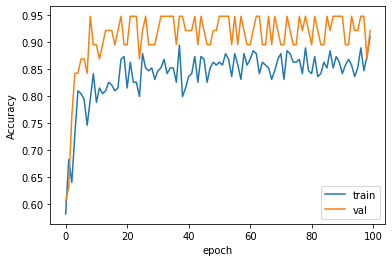

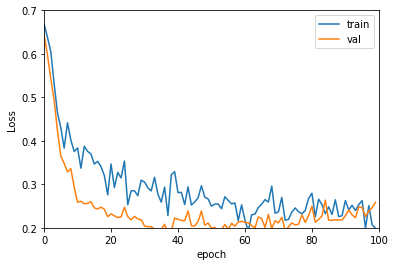

In [14]:
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.ylim([0.2,0.7])
plt.xlim([0,100])
plt.legend(['train', 'val'])
plt.show()

Load a trained model or the recently trained model
---

In [15]:
saved_weight_filepath = checkpoint_filepath;
# saved_weight_filepath = os.path.join(base_dir,'trained_weights.hdf5')
model.load_weights(saved_weight_filepath)

Prepare the visualization function
---

Grad-CAM
---
Slightly modified from
https://keras.io/examples/vision/grad_cam/
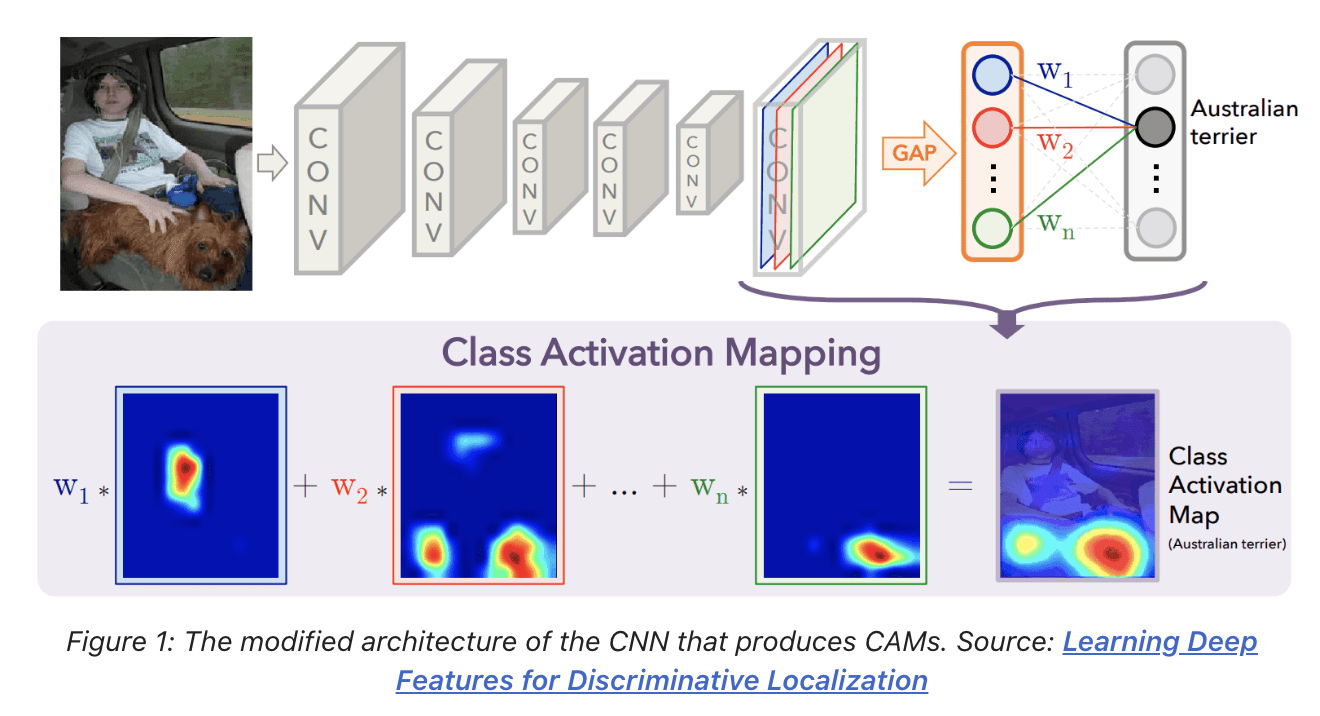

In [16]:
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
last_conv_layer = model.layers[-5]
grad_model = Model(inputs = model.input, outputs = [last_conv_layer.output, model.output])

def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # Take the index of the most likely class if pred_index is not specified
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Found 26 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step


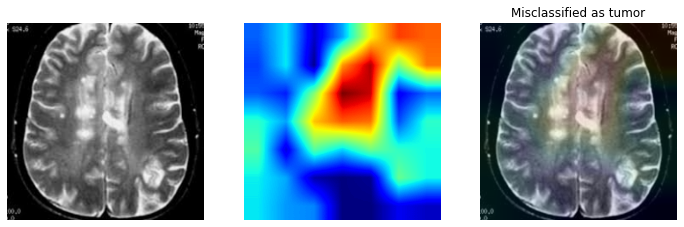

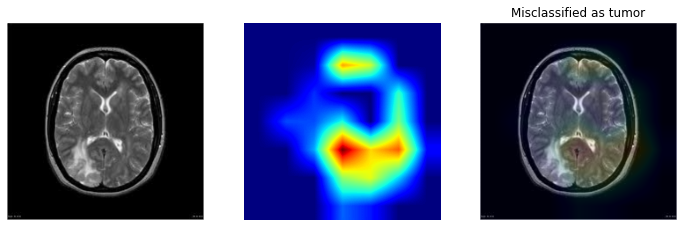

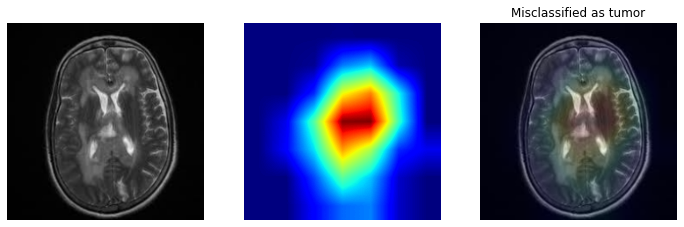

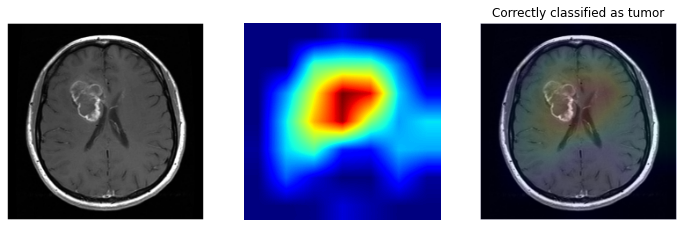

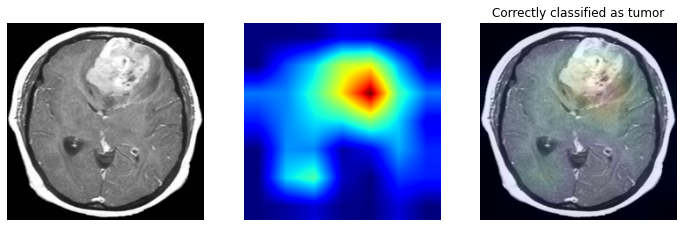

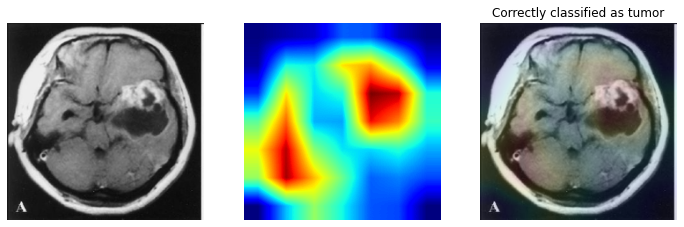

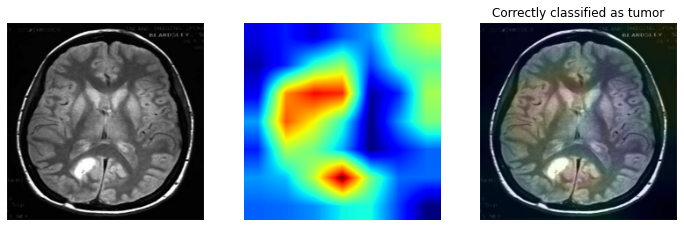

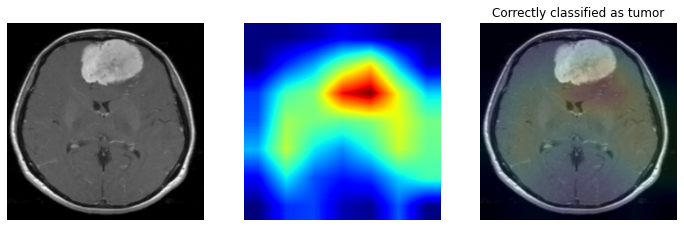

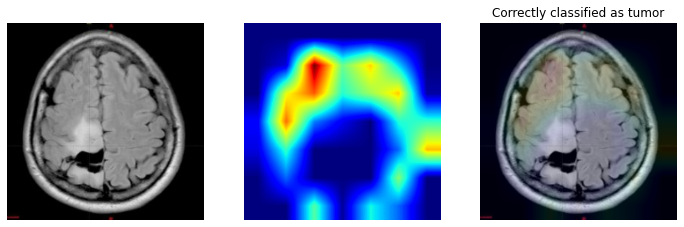

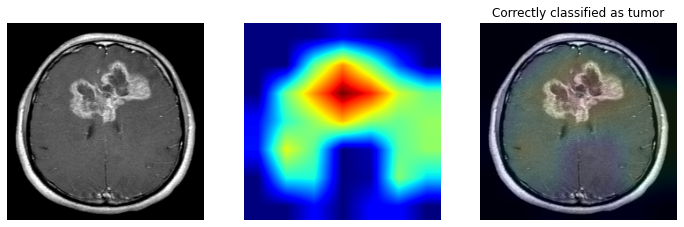

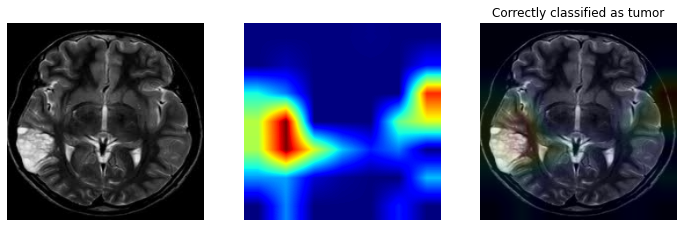

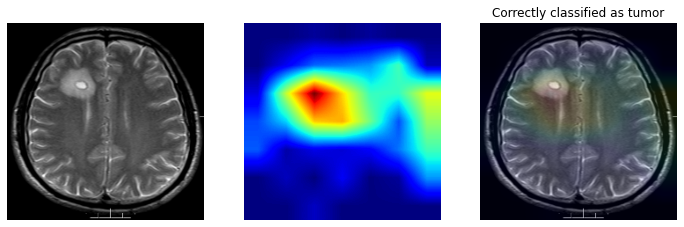

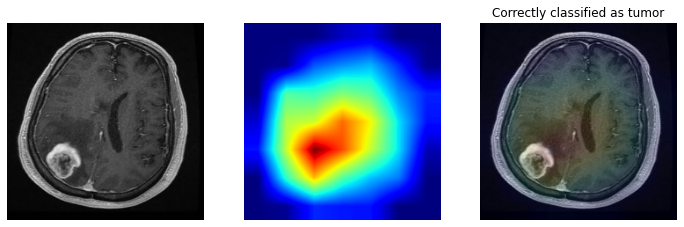

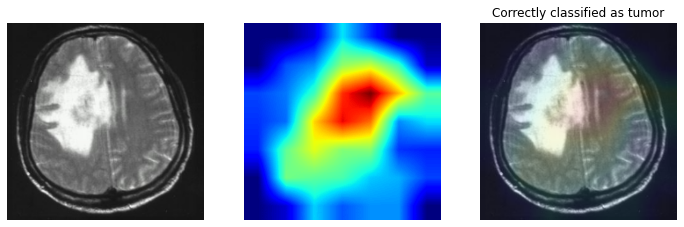

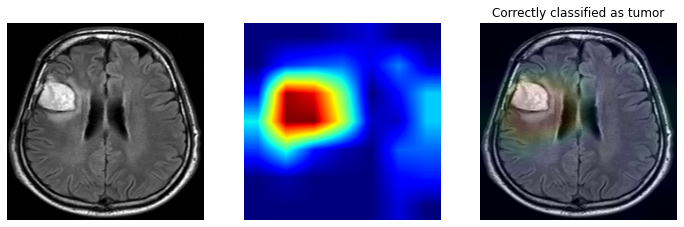

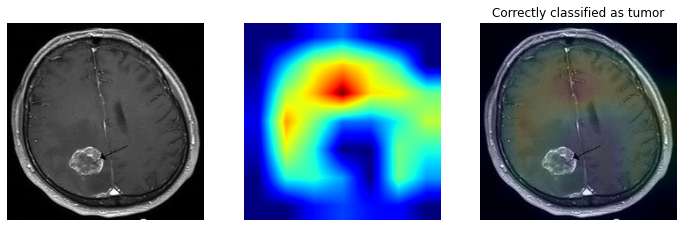

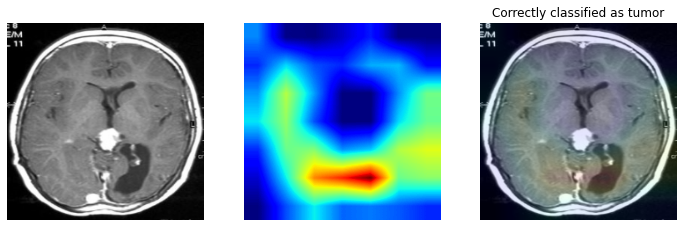

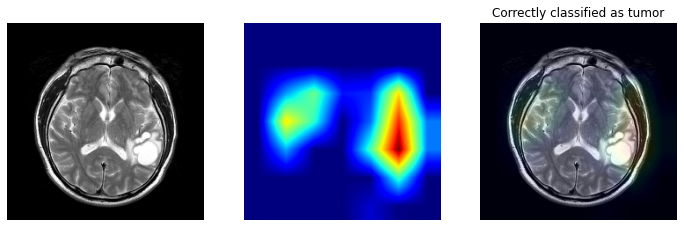

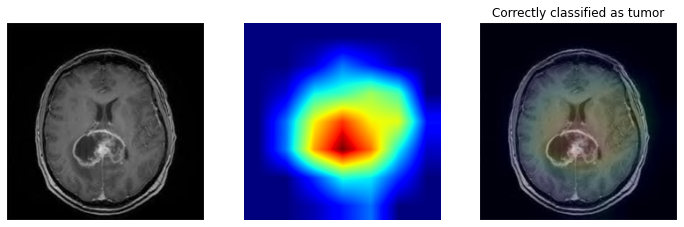

In [17]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        os.path.join(data_base_dir,'test'),
        classes = class_name_list,
        target_size=(im_size, im_size),
        batch_size=1,
        class_mode='categorical', 
        shuffle=False)

className2classIdx_dict = test_generator.class_indices
classIdx2className_dict = dict([(value, key) for key, value in className2classIdx_dict.items()])
    
class_name_list = []
for idx in range(len(classIdx2className_dict)):
    class_name_list.append(classIdx2className_dict[idx])

labels_true_int_format = np.zeros((test_generator.samples,))
labels_predicted_int_format = np.zeros((test_generator.samples))
for idx, (curr_img,curr_label_true_onehot) in enumerate(test_generator):
    
    if idx >= test_generator.samples:
        break
    
    labels_predicted_int_format[idx] = np.argmax(model.predict(curr_img),axis=-1)
    labels_true_int_format[idx] = np.argmax(curr_label_true_onehot,axis=-1)

    # Check the misclassified sample(s)
    if labels_predicted_int_format[idx] == className2classIdx_dict['tumor']:
        with Image.open(os.path.join(data_base_dir,'test',test_generator.filenames[idx])) as im:

            # Compute heatmaps
            heatmap = make_gradcam_heatmap(curr_img, grad_model)
            heatmap = cv2.resize(np.uint8(255 * heatmap), (224, 224))

            # Display images
            img = np.array(im) # The values are between 0 and 255
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(cv2.resize(np.uint8(img), (im_size, im_size))) #Allow 0-1 float or 0-255 int
            plt.axis('off')
            plt.gray()
            plt.subplot(1,3,2)
            plt.imshow(heatmap, cmap = 'jet')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(cv2.resize(np.uint8(img), (im_size, im_size))) #Allow 0-1 float or 0-255 int
            plt.axis('off')
            plt.gray()
            plt.imshow(heatmap,  alpha = 0.1, cmap = 'jet')

            if labels_predicted_int_format[idx] != labels_true_int_format[idx]:
                plt.title('Misclassified as ' + classIdx2className_dict[labels_predicted_int_format[idx]])
            else:
                plt.title('Correctly classified as ' + classIdx2className_dict[labels_predicted_int_format[idx]])

test_acc = np.sum(labels_true_int_format==labels_predicted_int_format)/labels_true_int_format.shape[0]*100

Test accuracy =  88.46153846153845


<Figure size 432x288 with 0 Axes>

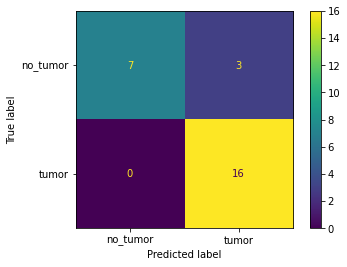

In [18]:
print('Test accuracy = ', test_acc)
plt.figure()
ConfusionMatrixDisplay.from_predictions(labels_true_int_format, labels_predicted_int_format,display_labels=class_name_list)